In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

from imblearn.under_sampling import RandomUnderSampler
import random
random.seed(42)

In [2]:
websites=["akakce","amazon","arabam","donanimhaber","haberturk","mgm","nefisyemektarifleri","pazarama","trendyol"]

datas=[]
for website in websites:
    data=pd.read_csv(website+"_paired.csv",encoding='latin1')
    data = data.groupby("pair").apply(lambda x: x.sample(min(184,len(x)))).reset_index(drop=True)
    print(website,data.shape)
    datas.append(data)
data=pd.concat(datas,ignore_index=True)
#drop the rows with pair value count is 1
valuecounts=data["pair"].value_counts()
data["pairC"] = data["pair"].map(lambda x: valuecounts[x])
data = data[data["pairC"] > 1].reset_index(drop=True)
print(data.shape)
data.head()

akakce (2217, 6)
amazon (2927, 6)
arabam (4027, 6)
donanimhaber (773, 6)
haberturk (28327, 6)
mgm (3936, 6)
nefisyemektarifleri (2468, 6)
pazarama (1536, 6)
trendyol (1357, 6)
(45943, 7)


,url1,url2,url1_dir,url2_dir,pair,identical,pairC
0,https://www.akakce.com/brosurler/a101,https://www.akakce.com/yorum/?p=131983292#Yoru...,www.akakce.com/78,www.akakce.com/79,aktcom,False,3
1,https://www.akakce.com/brosurler/a101,https://www.akakce.com/yorum/?p=1958594929,www.akakce.com/78,www.akakce.com/80,aktcom,False,3
2,https://www.akakce.com/brosurler/a101,https://www.akakce.com/yorum/?p=436908675#Yoru...,www.akakce.com/78,www.akakce.com/81,aktcom,False,3
3,https://www.akakce.com/brosurler/a101,https://www.akakce.com/,www.akakce.com/78,www.akakce.com/90,akthome,False,2
4,https://www.akakce.com/brosurler/a101,https://www.akakce.com/#/9876/?z=144&v=2108&s=...,www.akakce.com/78,www.akakce.com/89,akthome,False,2


In [11]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Concatenate, Flatten
from tensorflow.keras.models import Model

input_shape = (256, 256, 3)
input_1 = Input(shape=input_shape, name='input_1')
input_2 = Input(shape=input_shape, name='input_2')

base_model = VGG19(include_top=False, weights='imagenet', input_shape=input_shape)
for l in base_model.layers[-10:]:
    l.trainable = False


features_1 = Flatten()(base_model(input_1))
features_2 = Flatten()(base_model(input_2))


combined = features_1- features_2

x = Dense(1024, activation='relu')(combined)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=[input_1, input_2], outputs=output)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-1,decay=1e-4), loss='binary_crossentropy', metrics=["accuracy",tf.keras.metrics.AUC(),tf.keras.metrics.SensitivityAtSpecificity(1)])

model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg19 (Functional)             (None, 8, 8, 512)    20024384    ['input_1[0][0]',                
                                                                  'input_2[0][0]']          

In [12]:
def load_and_preprocess_image(path, img_size=(256, 256)):
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=3)  
    image = tf.image.resize(image, img_size)
    image = tf.keras.applications.vgg19.preprocess_input(image)  # normalize for ResNet
    return image

def make_dataset(image_paths_1, image_paths_2, labels, batch_size=32, shuffle=True):
    path_ds_1 = tf.data.Dataset.from_tensor_slices(image_paths_1)
    path_ds_2 = tf.data.Dataset.from_tensor_slices(image_paths_2)
    label_ds = tf.data.Dataset.from_tensor_slices(labels)

    def process_pair(path1, path2, label):
        img1 = load_and_preprocess_image("data/"+path1+"/ss.png")
        img2 = load_and_preprocess_image("data/"+path2+"/ss.png")
        return {'input_1': img1, 'input_2': img2}, label

    dataset = tf.data.Dataset.zip((path_ds_1, path_ds_2, label_ds))
    dataset = dataset.map(process_pair, num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(labels))

    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

from sklearn.model_selection import train_test_split
train, test = train_test_split(
    data,stratify=data["pair"],
    test_size=0.2,
    random_state=42,
    shuffle=True,
)
train, val = train_test_split(
    train, stratify=train["pair"],
    test_size=0.2,
    random_state=42,
    shuffle=True,
)
train_dataset = make_dataset(train["url1_dir"].to_numpy(), train["url2_dir"].to_numpy(), train["identical"].to_numpy(), batch_size=32, shuffle=False)
val_dataset = make_dataset(val["url1_dir"].to_numpy(), val["url2_dir"].to_numpy(), val["identical"].to_numpy(), batch_size=32, shuffle=False)
test_dataset = make_dataset(test["url1_dir"].to_numpy(), test["url2_dir"].to_numpy(), test["identical"].to_numpy(), batch_size=32, shuffle=False)
# Train the model
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("vgg19.h5", save_best_only=True, monitor='val_loss', mode='min')

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

Epoch 1/50
919/919 [==============================] - 1168s 1s/step - loss: 4330824294327123968.0000 - accuracy: 0.8955 - auc_5: 0.4987 - sensitivity_at_specificity_5: 0.0000e+00 - val_loss: 9210704.0000 - val_accuracy: 0.9080 - val_auc_5: 0.4985 - val_sensitivity_at_specificity_5: 0.0000e+00
Epoch 2/50
919/919 [==============================] - 1077s 1s/step - loss: 0.3079 - accuracy: 0.9102 - auc_5: 0.5005 - sensitivity_at_specificity_5: 0.0000e+00 - val_loss: 0.3108 - val_accuracy: 0.9080 - val_auc_5: 0.5000 - val_sensitivity_at_specificity_5: 0.0000e+00
Epoch 3/50
919/919 [==============================] - 1090s 1s/step - loss: 0.3099 - accuracy: 0.9102 - auc_5: 0.4978 - sensitivity_at_specificity_5: 0.0000e+00 - val_loss: 0.3157 - val_accuracy: 0.9080 - val_auc_5: 0.5000 - val_sensitivity_at_specificity_5: 0.0000e+00
Epoch 4/50
919/919 [==============================] - 1077s 1s/step - loss: 0.3110 - accuracy: 0.9102 - auc_5: 0.4966 - sensitivity_at_specificity_5: 0.0000e+00 - val

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


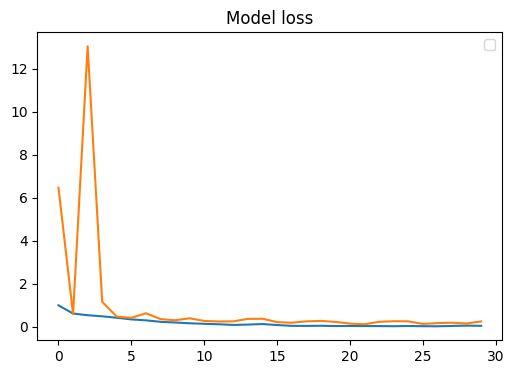

In [ ]:
from matplotlib import pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.show()

In [ ]:
model.evaluate(test_dataset, verbose=1)
model.save("models/vgg19.h5")

21/21 [==============================] - 3s 156ms/step - loss: 0.2906 - accuracy: 0.9398
